## Microsoft Dogs vs Cats Challenge

#### This is the second part of my DogsVsCats project.<br>In this part I'll try to create Neural Network that can differentiate cats and dogs with discant accuracy.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from tqdm import tqdm
from sklearn.utils import shuffle

sns.set_style('whitegrid')

In [3]:
from google.colab import drive
drive.mount("/content/drive")

training_data = np.load('/content/drive/My Drive/Notebooks/Deep/training_data.npy', allow_pickle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


### **Train test split**

The data consists of nearly 25000 images of dogs and cats.<br>And has almost equal images from each classes.

In [5]:
X = torch.tensor([i[0] for i in training_data]).view(-1,50,50)
y = torch.tensor([i[1] for i in training_data])

In [17]:
X = torch.tensor([i[0] for i in training_data]).view(-1,50,50)
y = torch.tensor([i[1] for i in training_data])

# Normalizing data
X = X / 255.

# Centering the data
X_train = X[:20000]
X_MEAN = X_train.mean()
X_train = X_train - X_MEAN
y_train = y[:20000]

X_test = X[20000:]
X_test = X_test - X_MEAN
y_test = y[20000:]

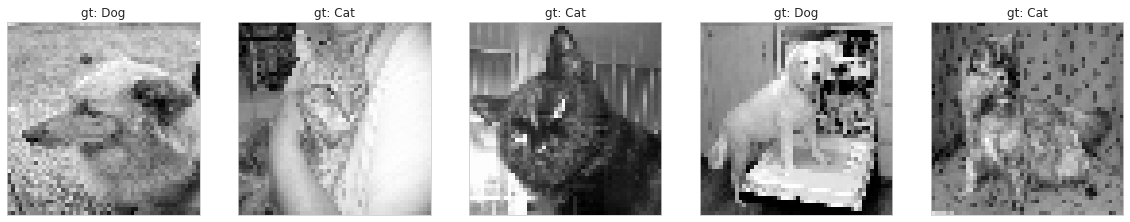

In [92]:
def checking_data(X, y, with_predictions=False, net=None):
  """"
  Drawing random images from given data, printing groud truth in the title.
  If with_predicions is True printing prediction for given X in the title as well.
  
  Parameters:
    X - type[tensor or np.array], features 
    y - type[tensor or np.array], labels
    with_predictions - type[bool], check predictions or not
    net - Neural network  
  """
  plt.figure(figsize=(20,8))
  a = np.random.randint(0, len(y), size=5)
  
  for i,k in enumerate(a):
    X_inner = X[k]
    label = torch.argmax(y[k])
    if label==1:
      label='Dog'
    else:
      label='Cat'

    if with_predictions:
      net.eval()
      with torch.no_grad():
        output = net(X_inner.view(1, 1, 50, 50).to(device))
        pred = torch.argmax(output)
        if pred==1:
          pred = 'Dog'
        else:
          pred = 'Cat'
        title = 'gt: ' + label + ' Pred: ' + pred
      
    else:
      title = 'gt: ' + label

    plt.subplot(1, 5, i+1)
    plt.imshow(X_inner.view(50,50), cmap='gray')
    plt.title(title, fontsize=12)
    plt.xticks([])
    plt.yticks([])

  plt.show()

checking_data(X_train, y_train)
print('')

## Creating model

As this is kind of a learning project I won't bother much about the architecture, and use an architecture, that seems 'logical' to me.<br>
In my next project I am going to focus more in architecture and try to create something meaningful.<br>
P.S. You can already find that project in my [GitHub](https://github.com/GevHovh).

In [93]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, 5)
    self.conv2 = nn.Conv2d(64,64, 5)
    self.max_pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv3 = nn.Conv2d(64,32, 3)
    self.conv4 = nn.Conv2d(32,32, 3)
    self.max_pool2 = nn.MaxPool2d(kernel_size=2)

    self._to_linear = None
    x = torch.randn(50,50).view(-1,1,50,50)
    x = self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 64)
    self.bn1 = nn.BatchNorm1d(64)
    self.fc2 = nn.Linear(64,64)
    self.bn2 = nn.BatchNorm1d(64)
    self.fc3 = nn.Linear(64, 2)

  def convs(self,x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.max_pool1(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.max_pool2(x)

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

    return x
  
  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x = self.fc3(x)

    return F.softmax(x, dim=1)

net = Net().to(device)

In [94]:
def calculating_loss(net, X, y, batch_size, loss_fn, optimizer, train_model=False):
  """
  Calculating loss for given parameters.
  Has option to train model(if train_model=True)
  """
  X, y = shuffle(X, y)

  for k in range(0, len(y), BATCH_SIZE):
    X_batch = X[k:k+BATCH_SIZE].to(device)
    y_batch = y[k:k+BATCH_SIZE].to(device)
    
    if train_model:
      net.train()
      net.zero_grad()
      outputs = net(X_batch.view(-1, 1, 50, 50))
      loss = loss_fn(outputs, y_batch.float())
      loss.backward()
      optimizer.step()    
    else:
      net.eval()
      with torch.no_grad():
        outputs = net(X_batch.view(-1, 1, 50, 50))
        loss = loss_fn(outputs, y_batch.float())

  loss = float(loss)
  loss = np.round(loss, 2)

  return loss

def calculating_acc(net, X, y):
  """
  Calculating accuracy for given network and data.
  """
  correct = 0
  total = 0

  net.eval()
  with torch.no_grad():
    for i in range(len(y)):
      label = int(torch.argmax(y[i]))
      X_inner = X[i].to(device)
      output = net(X_inner.view(1, 1, 50, 50))
      pred = int(torch.argmax(output))
      
      if pred==label:
        correct += 1

      total += 1

  acc = correct / total * 100
  acc = np.round(acc, 2)

  return acc

In [95]:
EPOCHS = np.arange(10)
BATCH_SIZE = 32
LR = 0.001
WD = 0.001
loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr =LR, weight_decay=WD)

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []

for epoch in tqdm(EPOCHS):
  # Training model
  train_loss = calculating_loss(net, X_train, y_train, BATCH_SIZE, loss_fn, optimizer, train_model=True)
  train_loss_array.append(train_loss)

  # Calculating test loss
  test_loss = calculating_loss(net, X_test, y_test, BATCH_SIZE, loss_fn, optimizer, train_model=False)
  test_loss_array.append(test_loss)

  # Calculating train acc
  train_acc = calculating_acc(net, X_train, y_train)
  train_acc_array.append(train_acc)

  # Calculating test acc
  test_acc = calculating_acc(net, X_test, y_test)
  test_acc_array.append(test_acc)









  0%|          | 0/10 [00:00<?, ?it/s]







 10%|█         | 1/10 [00:48<07:16, 48.49s/it]







 20%|██        | 2/10 [01:37<06:28, 48.57s/it]







 30%|███       | 3/10 [02:25<05:39, 48.53s/it]







 40%|████      | 4/10 [03:13<04:50, 48.46s/it]







 50%|█████     | 5/10 [04:02<04:02, 48.50s/it]







 60%|██████    | 6/10 [04:50<03:13, 48.41s/it]







 70%|███████   | 7/10 [05:39<02:25, 48.40s/it]







 80%|████████  | 8/10 [06:27<01:36, 48.38s/it]







 90%|█████████ | 9/10 [07:15<00:48, 48.36s/it]







100%|██████████| 10/10 [08:04<00:00, 48.43s/it]


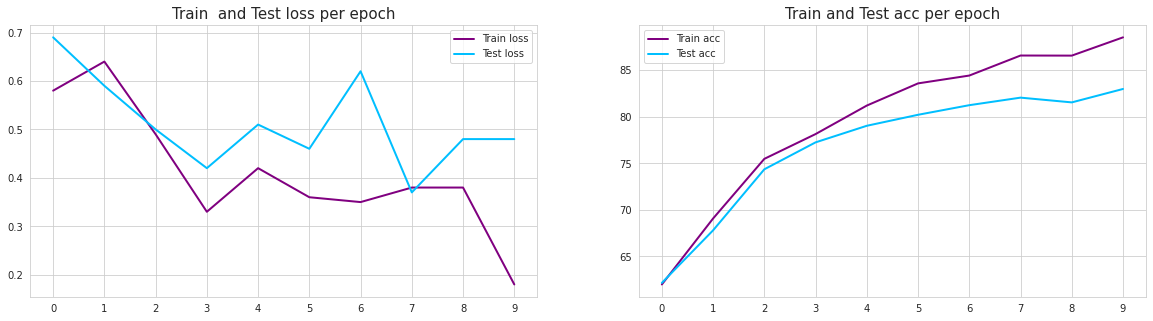

In [96]:
plt.figure(figsize=(20, 5))


plt.subplot(1, 2, 1)
sns.lineplot(x=EPOCHS, y=train_loss_array, color='purple', linewidth=2, label='Train loss')
sns.lineplot(x=EPOCHS, y=test_loss_array, color='deepskyblue', linewidth=2, label='Test loss')
plt.xticks(np.arange(0, len(train_loss_array), 1))
plt.legend()
plt.title('Train  and Test loss per epoch', fontsize=15)

plt.subplot(1, 2, 2)
sns.lineplot(x=EPOCHS, y=train_acc_array, color='purple', linewidth=2, label='Train acc')
sns.lineplot(x=EPOCHS, y=test_acc_array, color='deepskyblue', linewidth=2, label='Test acc')
plt.xticks(np.arange(0, len(train_acc_array), 1))
plt.legend()
plt.title('Train and Test acc per epoch', fontsize=15)


plt.show()

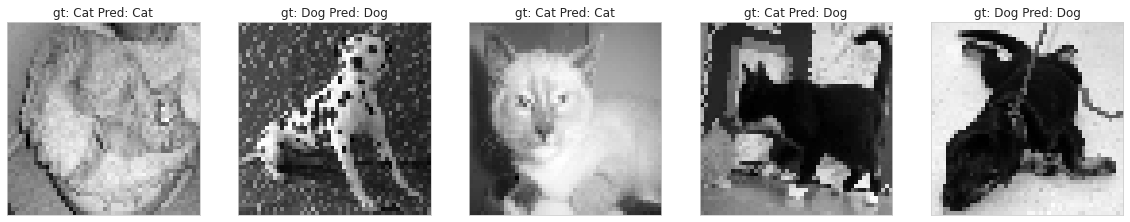

In [106]:
checking_data(X_test, y_test, with_predictions=True, net=net)

In [108]:
print('Final test accuracy:')
calculating_acc(net, X_test, y_test)

Final test accuracy:


82.98